In [ ]:
#reference https://github.com/nzw0301/keras-examples/blob/master/vae_cifar10_z2.ipynb

# Setup

In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model, load_model
from keras.datasets import cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import RMSprop, Adagrad, Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from pprint import pprint

C:\Users\Sophie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# CIFAR10

In [2]:
# Reference architecture from
# https://blog.keras.io/building-autoencoders-in-keras.html

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

im_shape = x_train[0].shape
input_dim = np.prod(im_shape)
original_dim = input_dim
x_train = x_train.astype('float32').reshape(x_train.shape[0], input_dim)/255.
x_test = x_test.astype('float32').reshape(x_test.shape[0], input_dim)/255.

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512 # hyperparameter
batch_size = 100
latent_dim = 2 # hyperparameter
epochs = 50

In [34]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 1)
(10000, 3072)
(10000, 1)


In [36]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape)
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [37]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

In [38]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [39]:
# encoder, from inputs to latent space
encoder = Model(inputs, [z_mean, z_log_sigma, z])

In [40]:
# build decorder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [41]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs)

In [42]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [43]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
model_4 (Model)              [(None, 2), (None, 2), (N 1575428   
_________________________________________________________________
model_5 (Model)              (None, 3072)              1577472   
Total params: 3,152,900
Trainable params: 3,152,900
Non-trainable params: 0
_________________________________________________________________


In [44]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

sgd = SGD()
adam = Adam()
vae.add_loss(vae_loss)
vae.compile(optimizer=adam)

# Training

In [45]:
vae_hist = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 73s 1ms/step - loss: 1994.4049 - val_loss: 1964.2826
Epoch 2/50
50000/50000 [==============================] - 86s 2ms/step - loss: 1961.3017 - val_loss: 1964.2137
Epoch 3/50
50000/50000 [==============================] - 84s 2ms/step - loss: 1959.9615 - val_loss: 1962.1303
Epoch 4/50
50000/50000 [==============================] - 84s 2ms/step - loss: 1959.1977 - val_loss: 1961.1424
Epoch 5/50
50000/50000 [==============================] - 85s 2ms/step - loss: 1958.5257 - val_loss: 1960.8851
Epoch 6/50
50000/50000 [==============================] - 84s 2ms/step - loss: 1958.1178 - val_loss: 1962.2238
Epoch 7/50
50000/50000 [==============================] - 85s 2ms/step - loss: 1957.7883 - val_loss: 1960.3904
Epoch 8/50
50000/50000 [==============================] - 81s 2ms/step - loss: 1957.4626 - val_loss: 1960.2893
Epoch 9/50
50000/50000 [==============================] - 80s 

In [17]:
# save model
vae.save("./runs/vae-cifar10.h5")

In [46]:
vae_hist = vae_hist.history

In [47]:
# save history
with open('./runs/vae-cifar10.hist', 'w', encoding="utf-8") as fout:
    pprint(vae_hist, fout)

In [48]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="train")
    plt.plot(iterations, test, label="test")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

# Loss graph

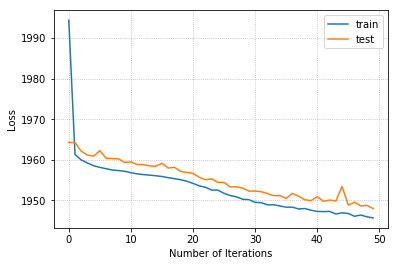

In [49]:
# show loss graph
plotLoss(vae_hist['loss'], vae_hist['val_loss'])

# Photo gallery

In [53]:
x_test_encoded = vae.predict(x_test, batch_size=batch_size)

In [54]:
def photogallery(photos):
    fig = plt.figure(figsize=(4, 12))
    for i, entry in enumerate(photos):
        ax1 = fig.add_subplot(10,2,i*2+1)
        ax1.imshow(entry[0])
        ax2 = fig.add_subplot(10,2,i*2+2)
        ax2.imshow(entry[1])

original, vae


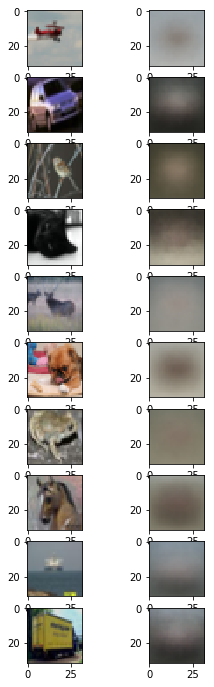

In [57]:
np.random.seed(42)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
photos = []

print("original, vae")
for digit in digits:
    index0 = np.where(y_test==digit)[0]
    pick = index0[np.random.choice(index0.shape[0])]
    #digit_indexes.append(pick)
    #print(pick)
    #print(im_shape)
    original = x_test[pick].reshape(32, 32, 3)
    encoded = x_test_encoded[pick].reshape(32, 32,3)
    photos.append([original, encoded])
    
photogallery(photos)

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded = x_test_encoded[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()